# Transformerの実装(分類タスク用)
Transformerは2017年以降多く使用されるようになった，Attentionを活用した自然言語処理モデル  

## これまでの自然言語処理とTransformerの関係
前節のDataLoaderで取り出したデータのポジネガ分類を行うモデルを構築  
そのまえに技術的背景について解説

### 文脈理解の必要性
言語データは画像データとは違い，前から順番に逐次的に処理する  
ある単語が入力される際にはそれまでに入力された単語の情報を保持し，文脈を理解する必要がある．この文脈を保持しておく脳の機能をワーキングメモリと呼ぶ  
  
例えば，突然「買った」という単語が入力されても意味がわからないが，「昨日，リンゴを」に続いて「買った」という単語が入力されたら意味がわかる．しかし，画像データは画像単体で意味を有する．

### 逐次データ処理は再帰的ネットワークからCNNへ
逐次的なデータ処理にはRNNやLSTMが使用されてきた．  
しかし，RNN,LSTMは学習時間が長くかかるという問題がある．  
1stepに1単語ずつ入力するため，一発で処理できる画像よりも時間がかかる．  
そこで，CNNや全結合層を使用して逐次的データを処理する手法が考案された．  
  
そもそもBag-of-Wordsのような語順情報を捨てた表現もそれなりの性能がある．
言語データにCNNを使用することは，Bag-of-Wordsを一歩拡張し，畳み込みによって隣接する数単語の情報を1つの特徴量として表現することで，単語と単語の隣接情報を加味した情報処理をすることになる．  
このCNNによってRNNやLSTMより逐次データの学習が高速になった．  

### CNNは離れた単語の関連性を見出せない
しかし，CNNによる言語データの処理にも問題がある．  
隣接する単語の情報が特徴量にできても離れた単語との関係性が考慮できない．  
  
実際，テキストデータには離れた単語同士が関係していることが多々ある．  
「昨日，田中くんはマラソンに参加したそうだ，彼はまだ疲れている．」  
この文は，「田中くん」と「彼」が同じものであり，「マラソン」と「疲れている」の因果関係があるといった関連性を含んでいる．  

### Attentionで離れた位置の関係性を捉える
そこで，離れた位置にある情報の関係性を捉えるSelf-Attentionが使える．  
Self-Attentionのおさらいを行う．
- pointwise convolution: カーネルサイズ1の畳み込みを行う
- Attention Map: 各ピクセルを他のピクセルと掛け算し，類似度を求めたもの
- 入力データをまた別のpointwise convで変換し，Attention Mapと掛け算
  
このSelf-Attention，(および本書では紹介しないがSource-Target-Attention）を活用することとで，離れた位置の単語の関係性を考慮することができる．  

### Transformer
言語データに対してAttentionを使用する深層学習モデルが，「Attention is All You Need」で提案されたTransformerである．  
  
Transformerはその名の通り元は翻訳タスクのモデルとして提案された．  
例えば日本語を英語に翻訳するには，  
日本語→エンコーダネットワーク→圧縮情報→デコーダネットワーク→英語  
のようにして英語の翻訳文を得る．  
  
本書では，翻訳タスクではなく，感情分析のようなエンコーダのみを必要とするタスクを扱う．そのため，エンコーダネットワークについてのみ解説と実装を行う．

## Transformerのネットワーク構造
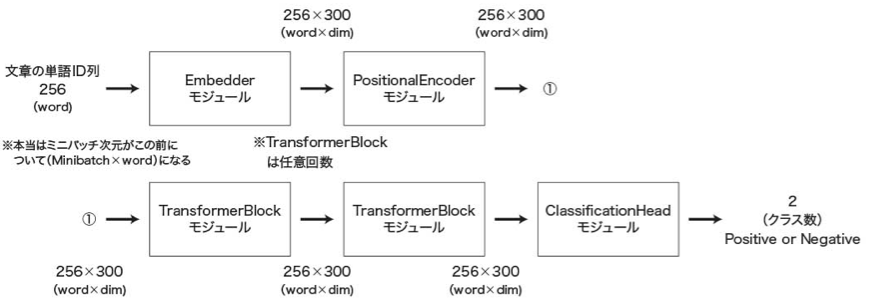

入力テンソルは(ミニバッチ数, 1文の単語数=256)である．  
上記画像の説明ではミニバッチの次元は省略してある．  

- Embedderモジュール: 入力単語はIDなので，ベクトル表現に変換
    - fasttextの英語学習済みベクトルを使用
    - ベクトル表現は300次元なので，(256, 300)が出力になる
- Positional Encoderモジュール: 位置情報テンソルを加算
    - 位置情報テンソルは(word=256, dim=300)のテンソル
    - Self-Attentionは語順をランダムにしても同様に処理してしまう
        - つまり，語順の概念がない
    - 位置情報テンソルは，語順情報の欠落問題を解決できる．
    - 位置情報テンソルに単語ベクトルの次元の情報は本来不要だが入れる
- TransformerBlockモジュール: SAでクラス分類できる特徴量へ変換する
    - 任意回数繰り返して使用する(本書では2段)
    - 出力サイズは入力サイズと同じ
    - mask: `<pad>`されている部分を0に置き換えSAがかからないようにする
        - デコーダ側では異なる使い方をするが本書では割愛
- ClassificationHeadモジュール: ポジネガクラス分類用モジュール
    - ただの全結合層
- 出力に対してネガ(0)ポジ(1)のラベルに対するCrossEntropyLossを取得
- 誤差逆伝播を繰り返し，学習
  
以下，実装に入っていく

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.dataloader import get_IMDb_DataLoaders_and_TEXT

In [2]:
train_dl, val_dl, test_dl, TEXT = get_IMDb_DataLoaders_and_TEXT()
batch = next(iter(train_dl))

## Embedderモジュール
単語IDに応じて単語ベクトルを与える  
PyTorchのnn.Embeddingというユニットを使用  
重みにTEXT.vocab.vectorsを与えればIDに応じた分散表現ベクトルを取得する

In [3]:
class Embedder(nn.Module):
    ''' id -> 単語分散表現ベクトル '''
    def __init__(self, text_embedding_vectors):
        super(Embedder, self).__init__()
        self.embeddings = nn.Embedding.from_pretrained(
            embeddings=text_embedding_vectors,
            freeze=True # バックプロパゲーションで更新されなくなる
        )
    
    def forward(self, x):
        x_vec = self.embeddings(x)
        return x_vec

動作確認

In [4]:
net1 = Embedder(TEXT.vocab.vectors)
x = batch.Text[0]
x1 = net1(x)

print("Input Size:", x.shape)
print("Output Size:", x1.shape)

Input Size: torch.Size([24, 256])
Output Size: torch.Size([24, 256, 300])


## Positional Encoderモジュール
単語の位置と分散表現の次元が一位に決まる位置情報テンソルを入力に加算  
位置情報テンソルは次の式で計算する  
$$ PE(pos_{word}, 2i) = \sin (pos_{word} / 10000^{2i/DIM}) $$
$$ PE(pos_{word}, 2i+1) = \cos (pos_{word} / 10000^{2i/DIM}) $$
  
- $PE$: Positional Encoding, 位置情報
- $pos_{word}$: その単語が何番目の単語か(ID?)
- $2i$: 単語の分散ベクトルの何次元目か
- $DIM$: 分散ベクトルの次元数, 今回は300
  
例えば，3番目の単語の5番目の次元のPositional Encoding値は  
$$ PE(3, 2 \times 2 + 1) = \cos ( 3 / 10000^{4 / 300} ) $$
  
この式は直感的には，sin, cosの相対的な足し算がやりやすいという特性をうまく使うために行なっている．  
また，実装では単語ベクトルがPositional Encodingよりも小さいので,単語ベクトルにroot(300)を掛け算し，大きさをある程度そろえて足し算している．

In [5]:
class PositionalEncoder(nn.Module):
    ''' 入力された単語の位置を示すベクトル情報を付加 '''
    def __init__(self, device, d_model=300, max_seq_len=256):
        super().__init__()

        self.d_model = d_model
        pe = torch.zeros(max_seq_len, d_model)
        
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model) ))
                pe[pos, i + 1] = math.cos(pos / 10000 ** ((2 * (i+1)) / d_model))
        
        # peの先頭にミニバッチの次元を足す
        self.pe = pe.unsqueeze(0)
        
        # 位置情報テンソルは勾配を計算しない
        self.pe.requires_grad = False
        
        # deviceにpeを渡す
        self.pe = self.pe.to(device)
    
    def forward(self, x):
        ret = math.sqrt(self.d_model) * x + self.pe
        return ret

動作確認

In [6]:
device = torch.device('cpu')
net1 = Embedder(TEXT.vocab.vectors)
net2 = PositionalEncoder(device, d_model=300, max_seq_len=256)

x = batch.Text[0]
x1 = net1(x)
x2 = net2(x1)

print("Input Size:", x1.shape)
print("Output Size:", x2.shape)

Input Size: torch.Size([24, 256, 300])
Output Size: torch.Size([24, 256, 300])


## TransformerBlockモジュール
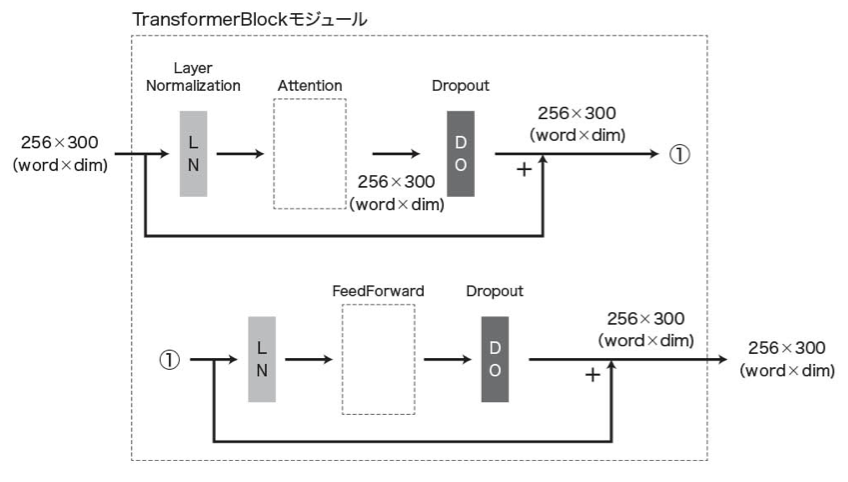

TransformerBlockモジュールは以下のユニットで構成される
- LayerNormalizationユニット
    - 単語の300個の特徴量を平均0,標準偏差1に正規化
- Dropout
- Attentionサブネットワーク
    - Attentionの出力をDropoutへ送り，その出力と入力を加算
- FeedForwardサブネットワーク
    - 2つの全結合層からなる単純なネットワーク
    - Attentionと同様，Dropoutした出力と入力を加算

複数個のAttentionを並列に使用するMulti-Headed Attentionを用いる  
しかし本書ではわかりやすさを優先し，単一のAttentionで実装  
  
Self-Attentionでは入力をpointwise convしていた.   
Transformerでは全結合層で特徴量変換  
  
`<pad>`を0にするが，計算できなくなってしまうため-1e9と大きな負の値にする  
これにより，ソフトマックスに入れるとAttention Mapが0に近い値になる  
(softmax(-inf) ≒ 0)

In [7]:
class Attention(nn.Module):
    def __init__(self, d_model=300):
        super().__init__()
        
        # SAGANでは1dConvを使用したが，ここでは全結合層を使う
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        
        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)
        
        # Attentionの大きさ調整の変数
        self.d_k = d_model
    
    def forward(self, q, k, v, mask):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)
        
        # Attentionの値を計算
        # 各値を足し算すると大きくなりすぎるのでroot(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)
        
        # ここでmaskを計算
        # 0になっているところを大きな負の値にし，Attentionがかからないようにする
        mask = mask.unsqueeze(1)
        weights = weights.masked_fill(mask == 0, -1e9)
        
        # softmaxで行ごとの規格化を行う
        normalized_weights = F.softmax(weights, dim=-1)
        
        # AttentionをValueと掛け算
        output = torch.matmul(normalized_weights, v)
        
        # 全結合層で特徴量を今一度変換
        output = self.out(output)
        return output, normalized_weights

FeedForwardとTransformerBlockを実装  
    normalized_weightsを出力できるよう設定し，SAを確認できるようにしておく

In [8]:
class FeedForward(nn.Module):
    ''' Attention層からの出力を単純に全結合層2つで特徴量変換するユニット '''
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        
        self.attn = Attention(d_model)
        
        self.ff = FeedForward(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        # 正規化とAttention
        x_normalized = self.norm_1(x)
        output, normalized_weights = self.attn(
            x_normalized, x_normalized, x_normalized, mask
        )
        
        x2 = x + self.dropout_1(output)
        
        # 正規化と全結合層
        x_normalized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normalized))
        
        return output, normalized_weights

動作確認

In [10]:
device = torch.device('cpu')

net1 = Embedder(TEXT.vocab.vectors)
net2 = PositionalEncoder(device, d_model=300, max_seq_len=256)
net3 = TransformerBlock(d_model=300)

x = batch.Text[0]
input_pad = 1 # <pad>のID
input_mask = (x != input_pad) # padでないところをTrueに
print(input_mask[0])

x1 = net1(x)
x2 = net2(x1)
x3, normalized_weights = net3(x2, input_mask)

print("Input Size:", x2.shape)
print("Output Size:", x3.shape)
print("Attention Size:", normalized_weights.shape)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
Input Size: torch.Size([24, 256, 300])
Output Size: torch.Size([24, 256, 300])
Attention Size: torch.Size([24, 256, 256])


## ClassificationHeadモジュール
ここまでの出力を全結合で2値分類する  
データによって文章の長さはまちまち  
なので，入力特徴量の先頭`<cls>`タグをつけたところのみを全結合で2値分類する  
  
ここで，Transformerそのものにセンタ等単語の特徴量にクラス分類のための情報が自然と集まるわけではないことに注意する．先頭単語の特徴量を使用して分類することで，その損失を逆伝播するため，先頭単語の特徴量が自然と文章のポジネガ判定に使われるよう学習する．

In [11]:
class ClassificationHead(nn.Module):
    def __init__(self, d_model=300, output_dim=2):
        super().__init__()
        
        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)
        
        # 重みを平均0,標準偏差0.02の正規分布で, バイアスを0で初期化する
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)
        
    def forward(self, x):
        # 各ミニバッチの先頭の単語の特徴量(300次元)のみを取り出す
        x0 = x[:, 0, :]
        out = self.linear(x0)
        return out

## Transformerの実装
ここまで作成したモジュールを組み合わせて分類タスク用のTransformerを実装  
TransformerBlockモジュールは2回繰り返す

In [12]:
class TransformerClassification(nn.Module):
    ''' Transformerでクラス分類させる '''
    def __init__(self, device, text_embedding_vectors, 
                 d_model=300, max_seq_len=256, output_dim=2):
        super().__init__()
        
        # モデル構築
        self.net1 = Embedder(text_embedding_vectors)
        self.net2 = PositionalEncoder(device, d_model=d_model, max_seq_len=max_seq_len)
        self.net3_1 = TransformerBlock(d_model=d_model)
        self.net3_2 = TransformerBlock(d_model=d_model)
        self.net4 = ClassificationHead(output_dim=output_dim, d_model=d_model)
    
    def forward(self, x, mask):
        x1 = self.net1(x)
        x2 = self.net2(x1)
        x3_1, normalized_weights_1 = self.net3_1(x2, mask)
        x3_2, normalized_weights_2 = self.net3_2(x3_1, mask)
        x4 = self.net4(x3_2)
        
        return x4, normalized_weights_1, normalized_weights_2

動作確認

In [13]:
device = torch.device('cpu')
net = TransformerClassification(
    device=device,
    text_embedding_vectors=TEXT.vocab.vectors,
    d_model=300,
    max_seq_len=256,
    output_dim=2
)
x = batch.Text[0]
input_mask = (x != input_pad)
out, normalized_weights_1, normalized_weights_2 = net(x, input_mask)

print("Output Size:", out.shape)
print("Output sigmoid[0]", F.softmax(out, dim=1)[0])

Output Size: torch.Size([24, 2])
Output sigmoid[0] tensor([0.2649, 0.7351], grad_fn=<SelectBackward>)


以上でTransformerの実装が完了．  
次節ではIMDbのDataLoaderに対してTransformerを学習させ，推論を実施する．  
また，Attentionによる相関関係の可視化を行う  
  
以上のTransformerClassificationはutilsに書いておく